In [103]:
import pandas as pd
import glob, os
import mahotas as mh
import numpy as np
import matplotlib as mpl

# from pylab import imshow
from skimage import io
import skimage
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

In [104]:
% ls

2016-0328-E11-seed.tif*                 2016-0328-H13.H14 composite- best.tif*
2016-0328-E11.E12 composite- worst.tif* 2016-0328-H14-extension.tif*
2016-0328-E12-extension.tif*            Thumbs.db*
2016-0328-H13-seed.tif*                 mt_analysis_demo.ipynb


(1040, 1392, 3)


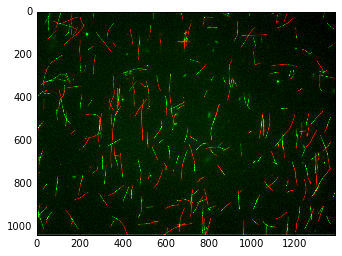

In [105]:
image = io.imread('2016-0328-E11.E12 composite- worst.tif')
imshow(image)
print(image.shape)

(1040, 1392)

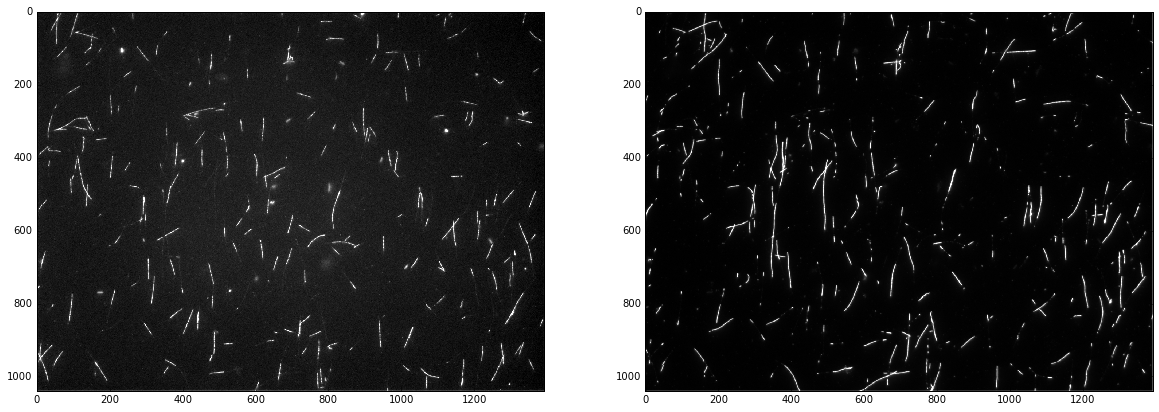

In [106]:
seed = image[..., 1]
mt = image[..., 0]

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 15))
ax1.imshow(seed)
ax2.imshow(mt)
mt.shape

(1040, 1392)


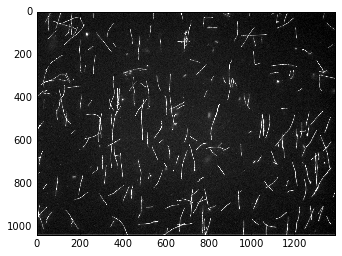

In [107]:
composite = np.maximum(seed, mt)
imshow(composite)
print(composite.shape)

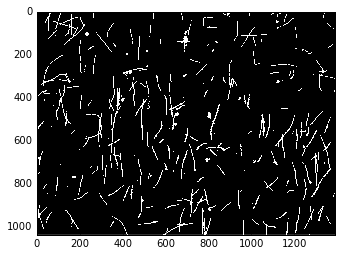

In [108]:
import skimage.filters

mask = skimage.filters.threshold_yen(composite)
composite_f = (composite > mask)


imshow(composite_f)


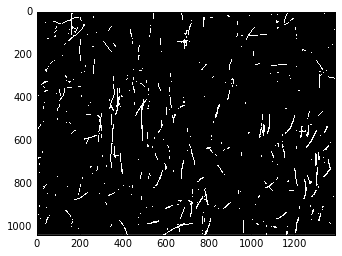

In [109]:
mt_mask = skimage.filters.threshold_yen(mt)
mt_f = (mt > mt_mask)

seed_mask = skimage.filters.threshold_yen(seed)
seed_f = (seed > mask)
imshow(mt_f)

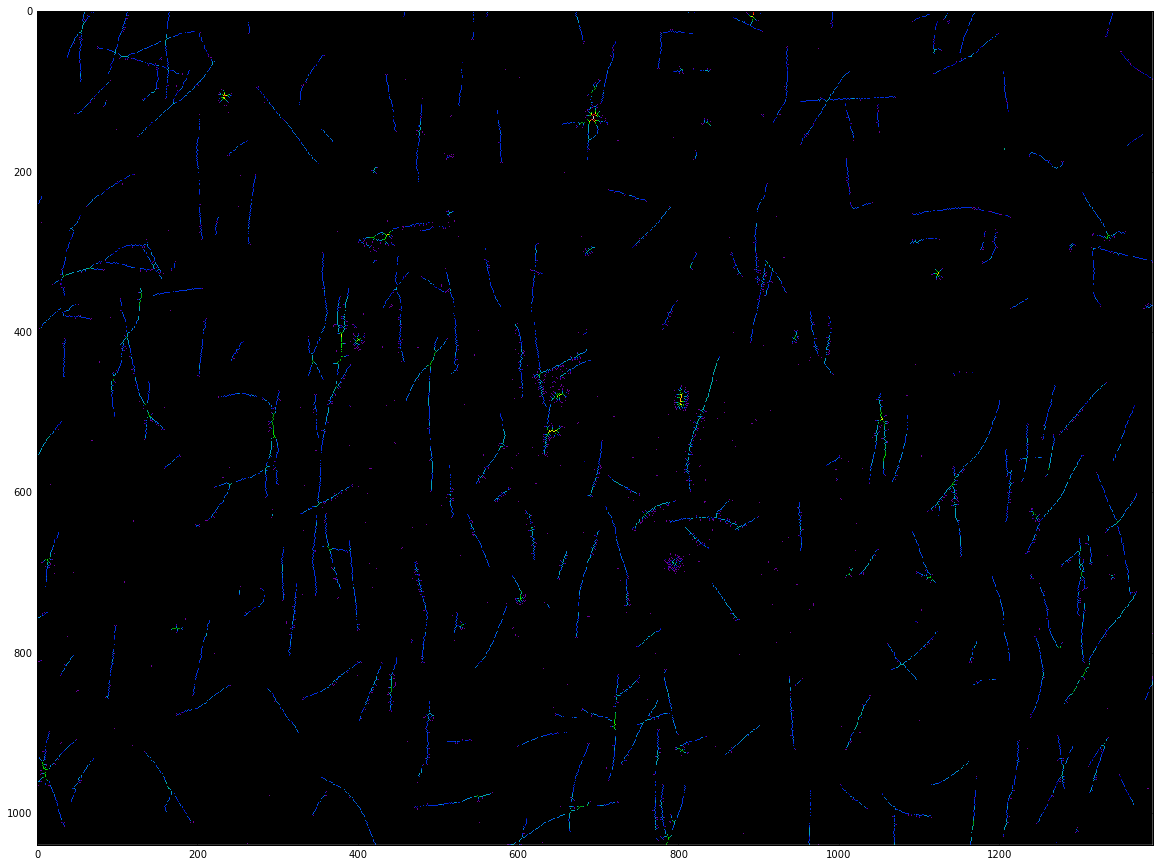

In [110]:
import skimage.morphology

skel, distance = skimage.morphology.medial_axis(composite_f, return_distance = True)
dist_on_skel = distance * skel

fig, ax1 = plt.subplots(1, 1, figsize = (20, 15))
ax1.imshow(dist_on_skel, cmap = plt.cm.spectral)

plt.show()

In [111]:
distance.shape

(1040, 1392)

In [112]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

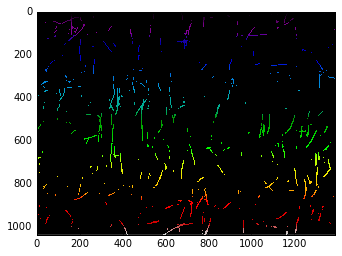

In [113]:
distance = ndi.distance_transform_edt(mt_f)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((5, 5)),
                            labels=mt_f)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=mt_f)

imshow(labels, cmap = 'spectral')

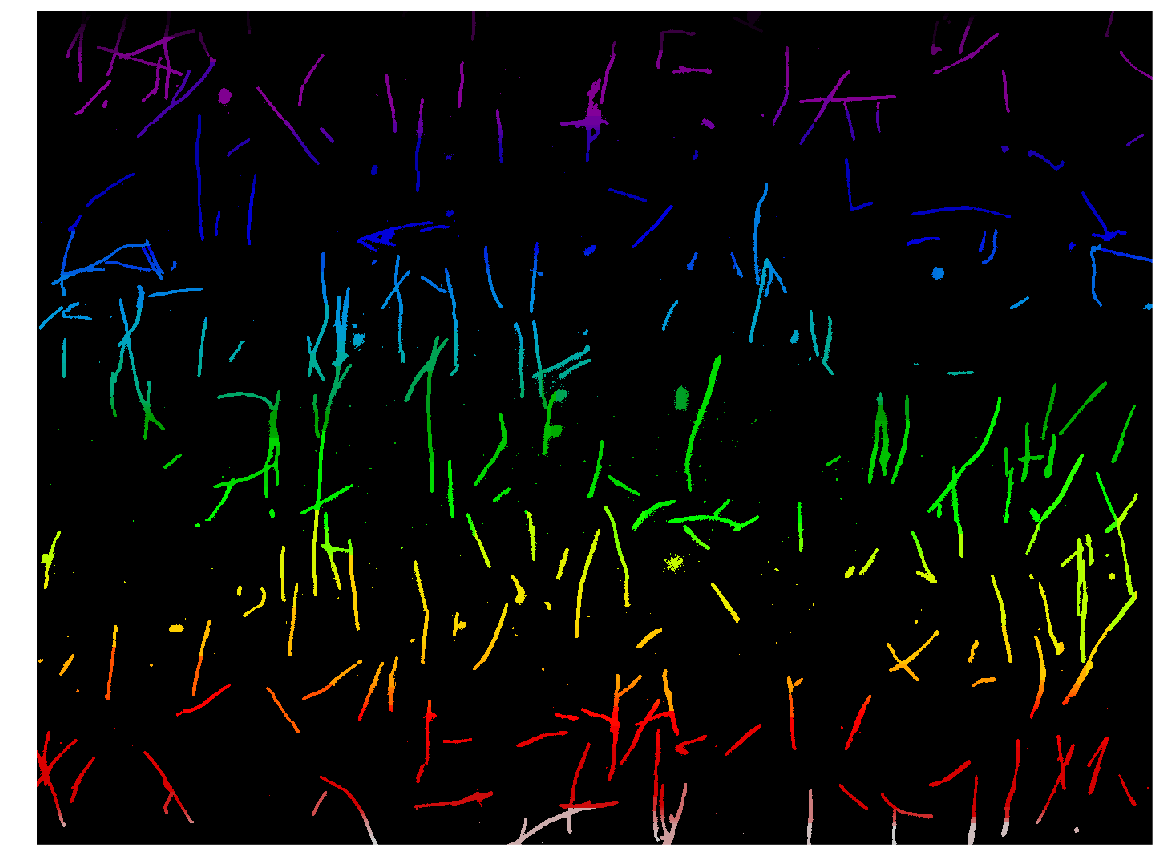

In [114]:
composite_f = np.maximum(seed_f, mt_f)



distance = ndi.distance_transform_edt(composite)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=composite_f)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=composite_f)

fig, ax = plt.subplots(1, 1, figsize = (20, 15))

ax.set_axis_off()
ax.imshow(labels, cmap = 'spectral')


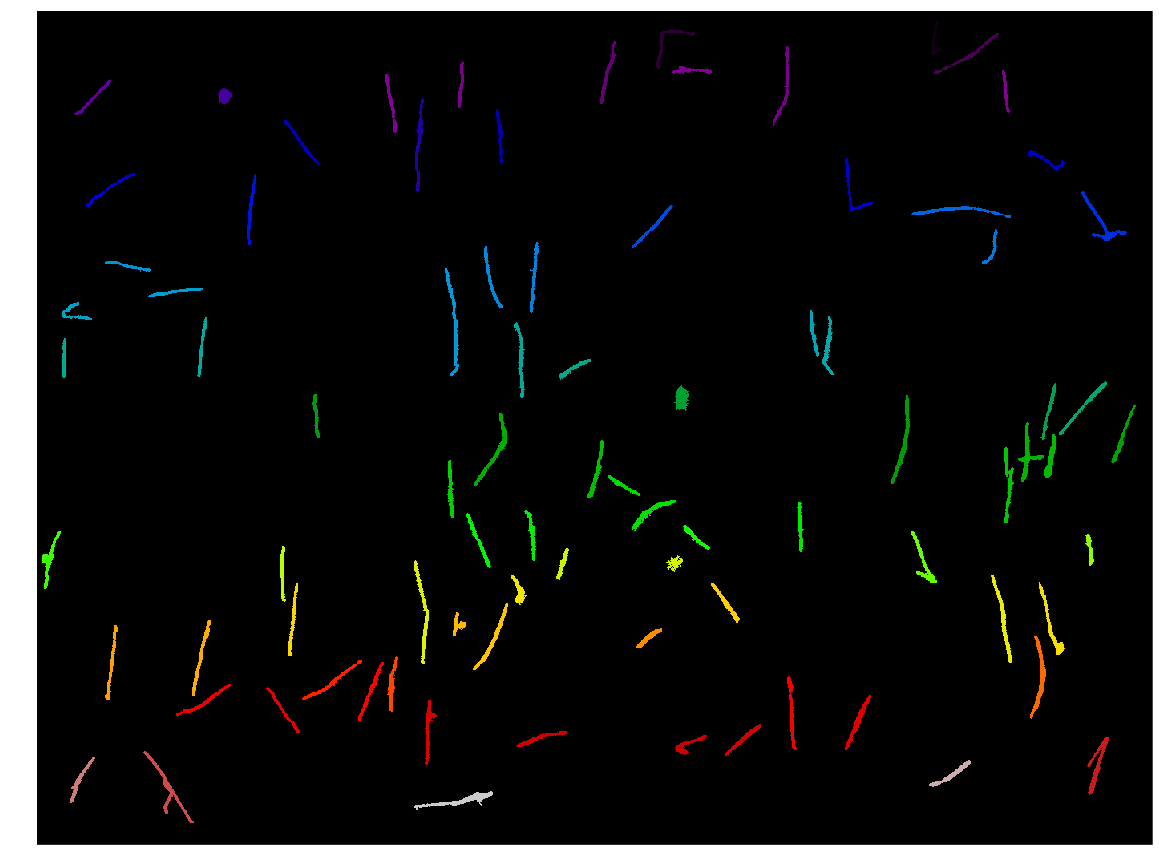

In [159]:
import mahotas as mh

labeled, number_mt = mh.label(labels)

#Remove congregated nuclei and micronuclei
sizes = mh.labeled.labeled_size(labeled)
too_big = np.where(sizes > 600)
labeled = mh.labeled.remove_regions(labeled, too_big)
too_small = np.where(sizes < 200)
labeled = mh.labeled.remove_regions(labeled, too_small)

# Remove cells at the borders
labeled = mh.labeled.remove_bordering(labeled)

# Relabel everthing
relabeled, n_final = mh.labeled.relabel(labeled)

# Labeling the nuclei whose size is between min and max size and not at the borders
# relabeled, numberOfNuclei = mh.labeled.filter_labeled(labeled, remove_bordering = True, max_size = max_size, min_size = min_size)

# Nuclear size
sizes = mh.labeled.labeled_size(relabeled)

fig, ax = plt.subplots(1, 1, figsize = (20, 15))

ax.set_axis_off()
ax.imshow(relabeled, cmap = 'spectral')

In [160]:
n_final

86

In [167]:
from scipy.misc import imsave

for i in range(1, n_final):
    mask = relabeled == i
    imsave('dynamic_MT_%s.png' %i, mask & mt_f)

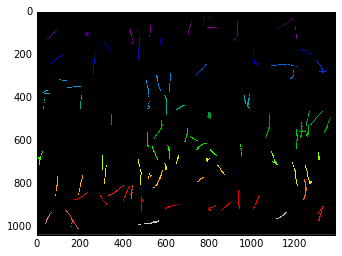

In [164]:
from skimage.measure import label, regionprops
from skimage.transform import rotate

mask = relabeled == 67

# regions = regionprops(seed & mask)

# for props in regions:
#     y0, x0 = props.centroid
#     orientation = props.orientation

# image_rotated = rotate(mask, angle = - orientation * 180 / np.pi, order = 0)

imshow(relabeled, cmap = 'spectral')

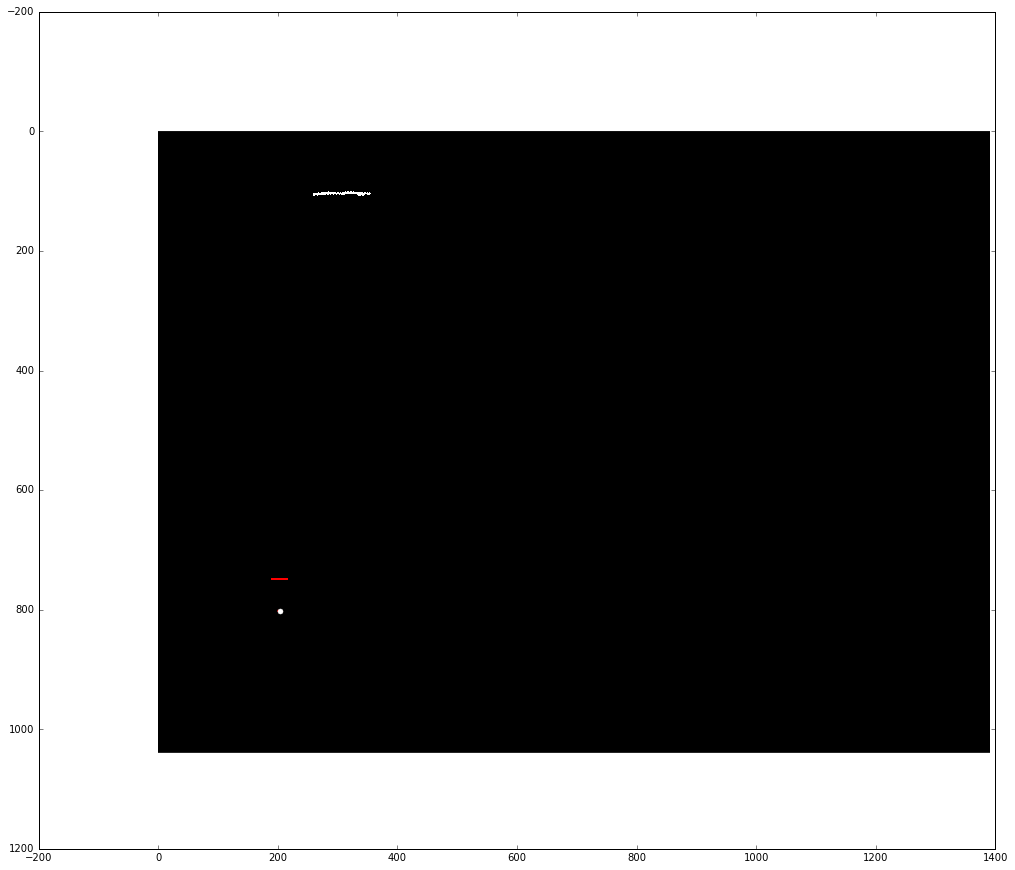

In [144]:
import math
for props in regions:
    y0, x0 = props.centroid
    y0 = int(y0)
    x0 = int(x0)
    orientation = props.orientation
    
    fig, ax = plt.subplots(figsize = (20, 15))
    ax.imshow(image_rotated)
    
    xr = int(x0 + math.cos(orientation) * 0.5 * props.major_axis_length)
    yr = int(y0 - math.sin(orientation) * 0.5 * props.major_axis_length)
    xl = int(x0 - math.cos(orientation) * 0.5 * props.major_axis_length)
    yl = int(y0 - math.sin(orientation) * 0.5 * props.major_axis_length)
    
    xt = int(x0 - math.sin(orientation) * 0.5 * props.minor_axis_length)
    yt = int(y0 - math.cos(orientation) * 0.5 * props.minor_axis_length)
    xb = int(x0 + math.sin(orientation) * 0.5 * props.minor_axis_length)
    yb = int(y0 + math.cos(orientation) * 0.5 * props.minor_axis_length)
    
    ax.plot((xl, xr), (yl, yr), '-r', linewidth=2)
    ax.plot((xt, xb), (yt, yb), '-r', linewidth=2)
    ax.plot(x0, y0, '.w', markersize=10)

In [30]:


for i in range(1, n_final):
    mask = relabeled == i
    plt.figure(i)
    plt.savefig(mask & mt_f)
    plt.savefig(mask & seed_f)

TypeError: Object does not appear to be a 8-bit string path or a Python file-like object

1453